### 準備

In [1]:
import torch
from tqdm import tqdm
from stable_baselines3 import PPO, SAC

from stable_baselines3.common.callbacks import EvalCallback

import os
import sys
sys.path.append(os.path.pardir)

from cpm_torch.CPM_Image import *
from cpm_torch.CPM import *
from cpm_torch.CPMEnv import *
from cpm_torch.Training.CPM_PPO import *
from cpm_torch.Training.CPM_Policy import *
from cpm_torch.Training.CPM_SAC_Policy import *

error: XDG_RUNTIME_DIR not set in the environment.


In [2]:
from datetime import datetime

def create_timestamped_results_dir(base_dir="results/PPOs"):
    """
    Creates a timestamped directory within the base results directory.
    
    Args:
        base_dir (str): Base directory where the timestamped folder will be created
        
    Returns:
        str: Path to the created directory
    """
    # Create the base directory if it doesn't exist
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    # Create a timestamp string
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Create the full path
    result_dir = os.path.join(base_dir, timestamp)
    
    # Create the directory
    os.makedirs(result_dir)
    
    print(f"Created results directory: {result_dir}")
    return result_dir


is_continue = False  # Set to True if you want to continue training from a previous model

if is_continue:
    result_dir = "results/PPOs/20250513-041642"  # Example directory for demonstration
    model_dir = os.path.join(result_dir, "recent_model")
else:
    result_dir = create_timestamped_results_dir()

Created results directory: results/PPOs/20250525-233545


### ハイパーパラメータ

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPUを利用します: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPUを利用します")

config = CPM_config(
    size=(64, 64),  # 画像サイズ
    l_A=1.0,  # 面積エネルギー項の係数λ_A
    l_L=1.0,  # 周囲長エネルギー項の係数λ_L
    A_0=75.0,  # 目標細胞面積 A_0
    L_0=40.0,  # 目標細胞周囲長 L_0
    T=1.0,  # 温度パラメータ T
)
print(config.__dict__)

GPUを利用します: NVIDIA H100 PCIe
{'size': (64, 64), 'dim': 2, 'height': 64, 'width': 64, 'depth': 1, 'l_A': 1.0, 'l_L': 1.0, 'A_0': 75.0, 'L_0': 40.0, 'T': 1.0}


### 環境

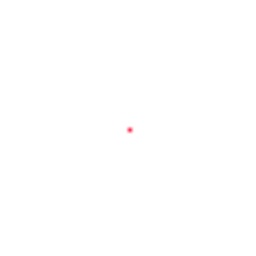

In [4]:
env = CPMEnv(config, device=device)  # CPM環境のインスタンスを作成
env.reset()  # 環境をリセット
env.render()  # 環境を描画

In [5]:
eval_freq = 10000
best_model_save_path = os.path.join(result_dir, "best_model")
n_eval_episodes = 10

eval_callback = EvalCallback(
    env,    # 評価環境
    log_path='path/to/log',
    eval_freq=eval_freq,
    deterministic=True,
    render=True,
    best_model_save_path=best_model_save_path,
    n_eval_episodes=n_eval_episodes
)

In [6]:
model = SAC(CPM_SAC_Policy, env, tensorboard_log=os.path.join(result_dir), verbose=1 )#batch_size=64)
# パラメータ数を表示
print(f"Number of parameters: {sum(p.numel() for p in model.policy.parameters())}")
for name, param in model.policy.named_parameters():
    print(f"{name}: {param.size()}")
print(model.policy)
model.learn(total_timesteps=1000000, progress_bar=True)  # 学習を実行

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Number of parameters: 38740912
actor.latent_pi.fc1.weight: torch.Size([256, 9])
actor.latent_pi.fc1.bias: torch.Size([256])
actor.latent_pi.fc2.weight: torch.Size([256, 256])
actor.latent_pi.fc2.bias: torch.Size([256])
actor.latent_pi.fc3.weight: torch.Size([128, 256])
actor.latent_pi.fc3.bias: torch.Size([128])
actor.latent_pi.fc_mean.weight: torch.Size([4, 128])
actor.latent_pi.fc_mean.bias: torch.Size([4])
actor.latent_pi.fc_log_std.weight: torch.Size([4, 128])
actor.latent_pi.fc_log_std.bias: torch.Size([4])
actor.mu.weight: torch.Size([1936, 256])
actor.mu.bias: torch.Size([1936])
actor.log_std.weight: torch.Size([1936, 256])
actor.log_std.bias: torch.Size([1936])
critic.qf0.u_net1.downs.0.double_conv.0.weight: torch.Size([64, 1, 3, 3])
critic.qf0.u_net1.downs.0.double_conv.0.bias: torch.Size([64])
critic.qf0.u_net1.downs.0.double_conv.1.weight: torch.Size([64])
critic.qf0.u_net1.downs.0

/root/.pyenv/versions/3.9.17/lib/python3.9/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

KeyboardInterrupt: 

In [ ]:

step = 200      # シミュレーションのエポック数
mcs_per_step = 20 # 1エポックあたりのCPMステップ数
diffusion_steps = 5 # 1 CPMステップあたりの拡散ステップ数

# オプション: 動画記録用ライターの初期化
video_filename = '../results/cpm_torch_jp.mp4'
writer = LoopWriter(filename=video_filename, fps=10) # ループ動画ライター

obs, _ = env.reset()  # 環境をリセット

# --- シミュレーション実行 ---
for i in tqdm(range(step), desc="ステップ"):
    for k in range(mcs_per_step):
        action, _  = model.predict(obs, deterministic=True)  # モデルに基づいて行動を選択
        obs, reward, _ , _, _ = env.step(action)
    
    # --- 動画フレーム追加 ---
    frame_rgb = map_tensor_to_rgb(obs)
    writer.add(frame_rgb)

writer.close()
imshow_map(obs)